In [1]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
import matplotlib as mpl
import gsw
import zarr
import gc
from tqdm import tqdm

In [ ]:
### Fresh Shelf 
## gamma < 28 

## Dense Shelf 
## gamma > 28 and T < 0.5C

## Warm Shelf
## gamma > 28 and T > 0.5C

In [2]:
IS = np.load('IS.npy')
ISX = np.load('ISX.npy')
ISY = np.load('ISY.npy')
IS[np.isnan(IS)] = 0

In [3]:
def classify(path, z1 = None, z2 = None):
    dataset = zarr.open(path, mode='r')
    
    if z1 is not None and z2 is not None:
        gamma = dataset['gamma'][z1:z2, :, :]
        T = dataset['THETA'][z1:z2, :, :]
    elif z1 is None and z2 is not None:
        gamma = dataset['gamma'][:z2,:,:]
        T = dataset['THETA'][:z2,:,:]
    elif z1 is not None and z2 is None:
        gamma = dataset['gamma'][z1:,:,:]
        T = dataset['THETA'][z2:,:,:]
    else:
        gamma = dataset['gamma'][:]
        T = dataset['THETA'][:]
        
    mask = dataset['insituT'][0,:,:]
    mask[~np.isnan(mask)] = 1
    T = T * mask[None, :, :]
        
    res = np.zeros((T.shape[1], T.shape[2]))
    
    for i in tqdm(range(res.shape[0])):
        for j in range(res.shape[1]):
            if ~np.isnan(T[0,i,j]):
                maxT = np.nanmax(T[:, i, j])
                maxg = np.nanmax(gamma[:, i, j])
                
                if maxg > 28 and maxT < 0.5: ## dense shelf
                    res[i,j] = 2
                elif maxg > 28 and maxT >= 0.5: ## warm shelf
                    res[i,j] = 3
                elif maxg < 28:## Fresh shelf
                    res[i,j] = 1
            else:
                continue
                
    return res

In [4]:
def classify16(path, z1 = None, z2 = None):
    dataset = zarr.open(path, mode='r')
    
    if z1 is not None and z2 is not None:
        gamma = dataset['gamma'][z1:z2, :, :]
        T = dataset['THETA_1-6'][z1:z2, :, :]
    elif z1 is None and z2 is not None:
        gamma = dataset['gamma'][:z2,:,:]
        T = dataset['THETA_1-6'][:z2,:,:]
    elif z1 is not None and z2 is None:
        gamma = dataset['gamma'][z1:,:,:]
        T = dataset['THETA_1-6'][z2:,:,:]
    else:
        gamma = dataset['gamma'][:]
        T = dataset['THETA_1-6'][:]
        
    res = np.zeros((T.shape[1], T.shape[2]))
    
    for i in tqdm(range(res.shape[0])):
        for j in range(res.shape[1]):
            if ~np.isnan(T[0,i,j]):
                maxT = np.nanmax(T[:, i, j])
                maxg = np.nanmax(gamma[:, i, j])
                
                if maxg > 28 and maxT < 0.5: ## dense shelf
                    res[i,j] = 2
                elif maxg > 28 and maxT >= 0.5: ## warm shelf
                    res[i,j] = 3
                elif maxg < 28:## Fresh shelf
                    res[i,j] = 1
            else:
                continue
                
    return res

# SOhi

In [12]:
data = data = zarr.open('/Volumes/workDrive/Shelf_Classification/SOhi.zarr', mode='r')
XC = data['lon_1-6'][:]
YC = data['lat_1-6'][:]
RC = data['depth'][:]

In [16]:
RC[75]

-305.30417

In [13]:
res = classify16('/Volumes/workDrive/Shelf_Classification/SOhi.zarr')
res[res==0] = np.nan

100%|███████████████████████████████████████████████████████| 586/586 [00:04<00:00, 141.08it/s]


In [14]:
np.save('data2/SOhi_XC.npy', XC)
np.save('data2/SOhi_YC.npy', YC)
np.save('data2/SOhi.npy', res)

/var/folders/2n/5cjcyrz92xq2s13y29jhm27w0000gn/T/ipykernel_6914/479082636.py:15: UserWarning: No contour levels were found within the data range.
  ax.contour(ISX%360,ISY, IS, levels=[0,1])


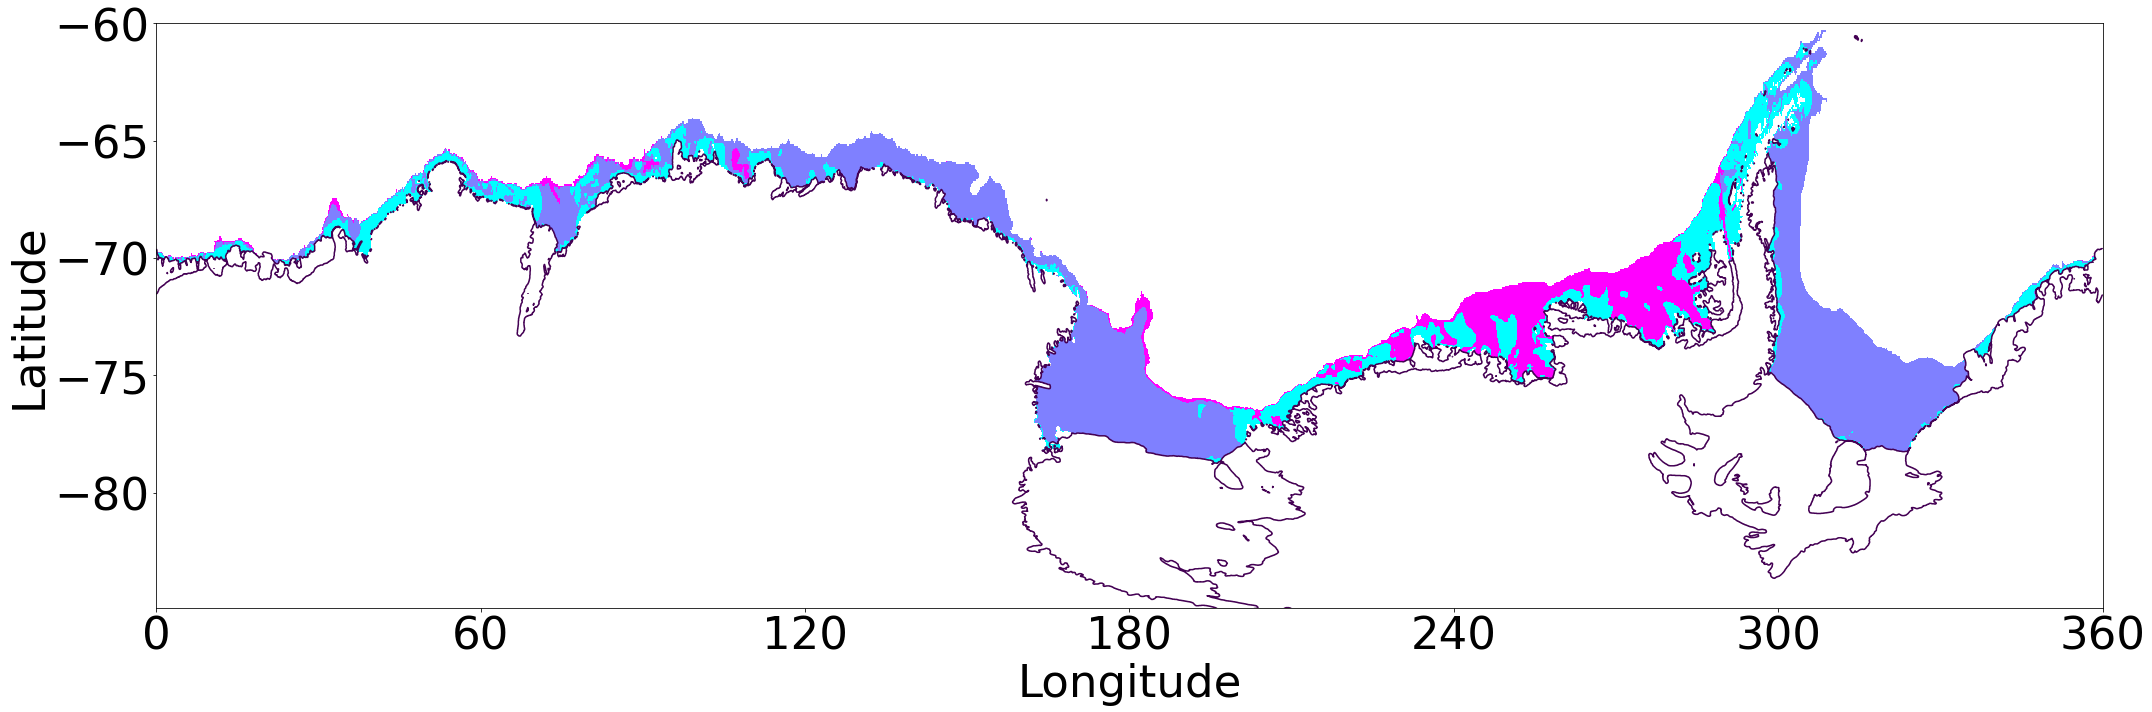

In [140]:
fig, ax = plt.subplots(figsize=(30,10))
#im = ax.pcolormesh(XC%360, YC, res)

cmap = plt.cm.get_cmap('cool')
# cmap.set_under('w')
# # cmap.set_over()  # do something here?
levels = np.asarray([0.5, 1.5, 2.5, 3.5])
im = ax.pcolormesh(XC%360, YC, res,
    cmap=cmap,
#     vmin=levels[0],
    # vmax=levels[-1],
    norm = mpl.colors.BoundaryNorm(levels, ncolors=cmap.N, clip=False)
)

ax.contour(ISX%360,ISY, IS, levels=[0,1])

# cbar_ax = fig.add_axes([0.1, 0.4, 0.35, 0.05])
# cbar = fig.colorbar(im, cax=cbar_ax,orientation='horizontal')
# cbar.ax.set_xlabel(f'', size=20)
# cbar.ax.set_xticks([1, 2, 3])
# cbar.ax.set_xticklabels(['Warm', 'Fresh', 'Dense'])
# cbar.ax.tick_params(labelsize=40)

ax.set_xlim(0,360)
ax.set_ylim(-84.9, -60)
ax.set_xticks(np.arange(0, 361, 60))

ax.set_xlabel('Longitude', fontsize=45)
ax.set_ylabel('Latitude', fontsize=45)
ax.tick_params(axis='both', labelsize=45)

# ax.grid()
plt.tight_layout()

plt.savefig('img/SOhi_ISclassify.jpg', dpi=300)

# LLC4320

In [5]:
data = data = zarr.open('/Volumes/workDrive/Shelf_Classification/LLC4320.zarr', mode='r')
XC = data['lon_1-6'][:]%360 
YC = data['lat_1-6'][:]
RC = data['depth'][:]

In [76]:
test = np.nanmax(XC, axis=0)

In [8]:
res = classify16('/Volumes/workDrive/Shelf_Classification/LLC4320.zarr')
res[res==0] = np.nan

res = np.concatenate((res[:, 228:],res[:, :228]), axis=1)
XC = np.concatenate((XC[:, 228:],XC[:, :228]), axis=1)
YC = np.concatenate((YC[:, 228:],YC[:, :228]), axis=1)

100%|███████████████████████████████████████████████████████| 563/563 [00:03<00:00, 162.50it/s]


In [9]:
np.save('data2/LLC_XC.npy', XC)
np.save('data2/LLC_YC.npy', YC)
np.save('data2/LLC.npy', res)

/tmp/ipykernel_63326/4088652535.py:8: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im = ax.pcolormesh(XC%360, YC, res,
/tmp/ipykernel_63326/4088652535.py:15: UserWarning: No contour levels were found within the data range.
  ax.contour(ISX%360,ISY, IS, levels=[0,1])


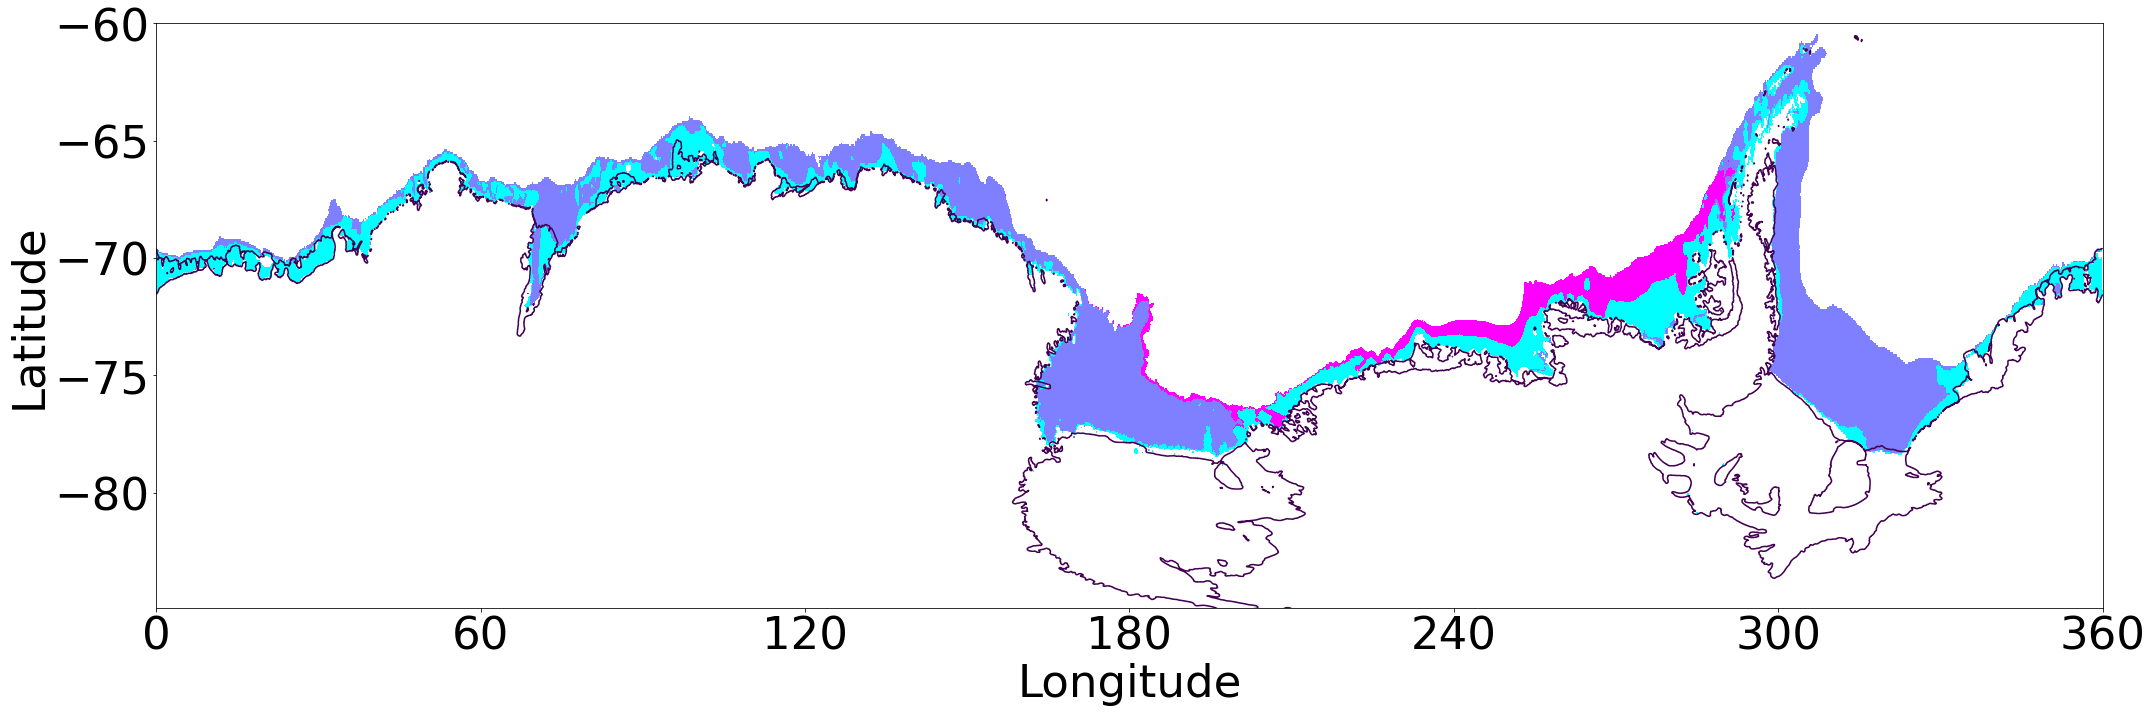

In [10]:
fig, ax = plt.subplots(figsize=(30,10))
#im = ax.pcolormesh(XC%360, YC, res)

cmap = plt.cm.get_cmap('cool')
# cmap.set_under('w')
# # cmap.set_over()  # do something here?
levels = np.asarray([0.5, 1.5, 2.5, 3.5])
im = ax.pcolormesh(XC%360, YC, res,
    cmap=cmap,
#     vmin=levels[0],
    # vmax=levels[-1],
    norm = mpl.colors.BoundaryNorm(levels, ncolors=cmap.N, clip=False)
)

ax.contour(ISX%360,ISY, IS, levels=[0,1])

# cbar_ax = fig.add_axes([0.1, 0.4, 0.35, 0.05])
# cbar = fig.colorbar(im, cax=cbar_ax,orientation='horizontal')
# cbar.ax.set_xlabel(f'', size=20)
# cbar.ax.set_xticks([1, 2, 3])
# cbar.ax.set_xticklabels(['Warm', 'Fresh', 'Dense'])
# cbar.ax.tick_params(labelsize=40)

ax.set_xlim(0,360)
ax.set_ylim(-84.9, -60)
ax.set_xticks(np.arange(0, 361, 60))

ax.set_xlabel('Longitude', fontsize=45)
ax.set_ylabel('Latitude', fontsize=45)
ax.tick_params(axis='both', labelsize=45)

# ax.grid()
plt.tight_layout()

plt.savefig('img/LLC_ISclassify.jpg', dpi=300)

### ECCO

In [148]:
res = classify('data/ECCO.zarr')
res[res==0] = np.nan

100%|██████████████████████████████████████████████████████████| 90/90 [00:00<00:00, 974.98it/s]


In [145]:
data = zarr.open('data/ECCO.zarr', mode='r')
XC = data['lon'][:]
YC = data['lat'][:]

mask = np.load('data/ECCO_mask.npy')
mask[np.isnan(mask)] = 0

In [127]:
data['depth'][19], data['depth'][23]

(-299.93, -552.71)

/var/folders/2n/5cjcyrz92xq2s13y29jhm27w0000gn/T/ipykernel_6914/1503725814.py:8: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im = ax.pcolormesh(XC%360, YC, res,
/var/folders/2n/5cjcyrz92xq2s13y29jhm27w0000gn/T/ipykernel_6914/1503725814.py:15: UserWarning: No contour levels were found within the data range.
  ax.contour(ISX%360,ISY, IS, levels=[0,1])


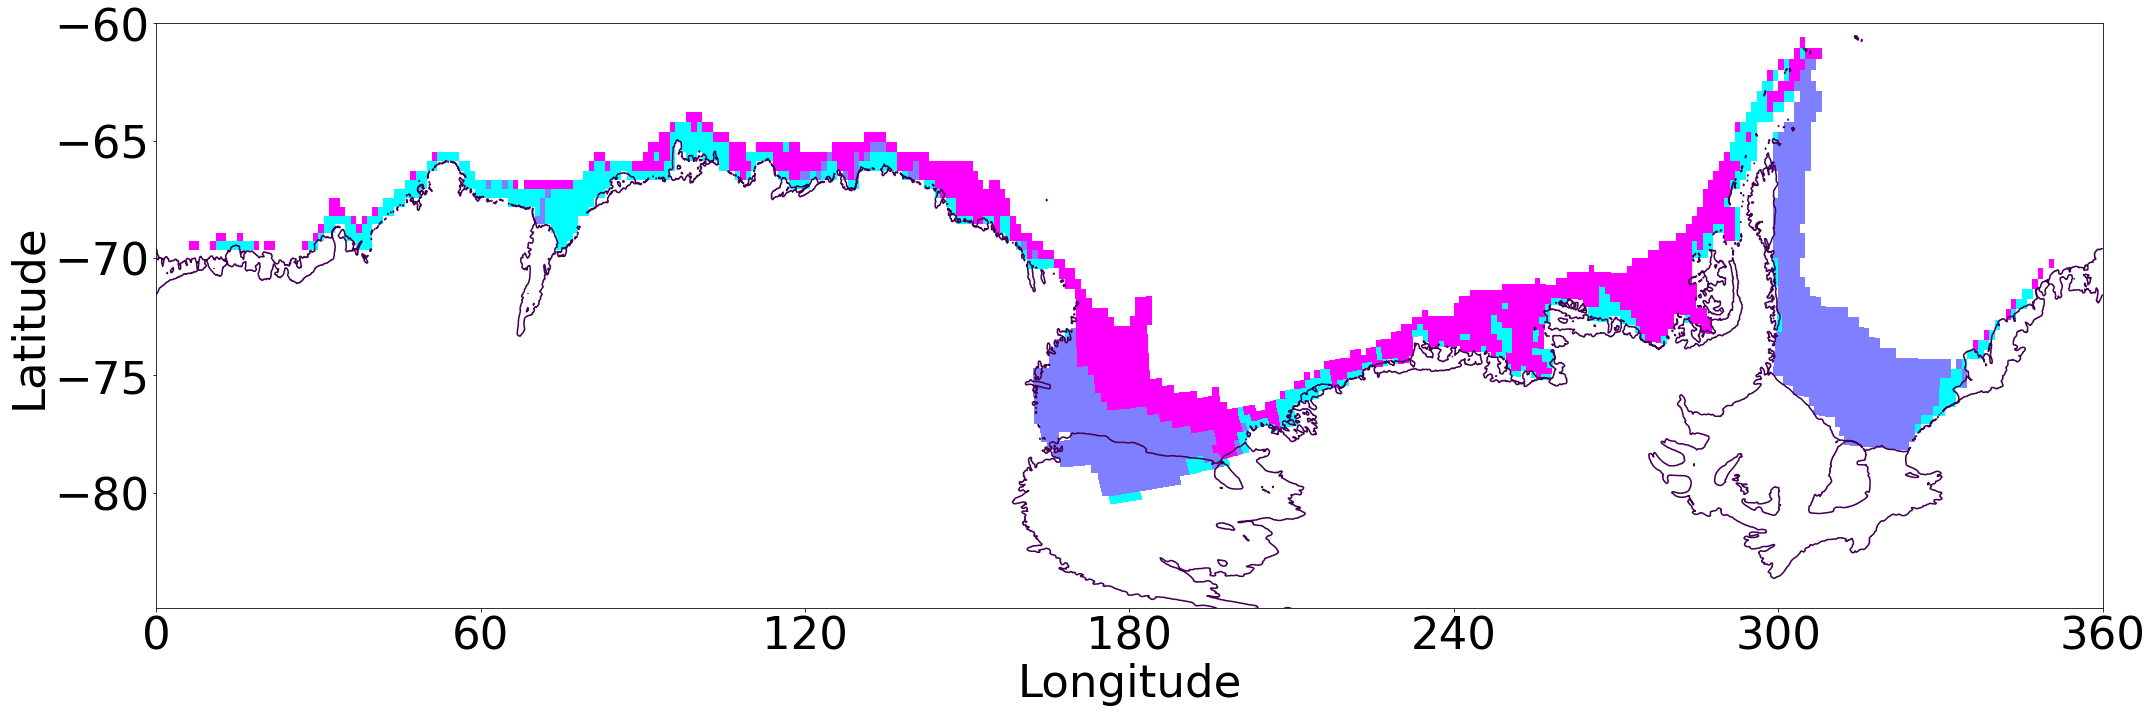

In [149]:
fig, ax = plt.subplots(figsize=(30,10))
#im = ax.pcolormesh(XC%360, YC, res)

cmap = plt.cm.get_cmap('cool')
# cmap.set_under('w')
# # cmap.set_over()  # do something here?
levels = np.asarray([0.5, 1.5, 2.5, 3.5])
im = ax.pcolormesh(XC%360, YC, res,
    cmap=cmap,
#     vmin=levels[0],
    # vmax=levels[-1],
    norm = mpl.colors.BoundaryNorm(levels, ncolors=cmap.N, clip=False)
)

ax.contour(ISX%360,ISY, IS, levels=[0,1])
# cbar_ax = fig.add_axes([0.1, 0.4, 0.35, 0.05])
# cbar = fig.colorbar(im, cax=cbar_ax,orientation='horizontal')
# cbar.ax.set_xlabel(f'', size=20)
# cbar.ax.set_xticks([1, 2, 3])
# cbar.ax.set_xticklabels(['Warm', 'Fresh', 'Dense'])
# cbar.ax.tick_params(labelsize=40)

ax.set_xlim(0,360)
ax.set_ylim(-84.9, -60)
ax.set_xticks(np.arange(0, 361, 60))

ax.set_xlabel('Longitude', fontsize=45)
ax.set_ylabel('Latitude', fontsize=45)
ax.tick_params(axis='both', labelsize=45)

# ax.grid()
plt.tight_layout()

plt.savefig('img/ECCO_ISclassify.jpg', dpi=300)

### SOSE

In [5]:
res = classify('data/SOSE.zarr')
res[res==0] = np.nan

100%|███████████████████████████████████████████████████████| 138/138 [00:00<00:00, 154.76it/s]


In [6]:
data = zarr.open('data/SOSE.zarr', mode='r')
XC = data['lon'][:]
YC = data['lat'][:]

mask = np.load('data/SOSE_mask.npy')
mask[np.isnan(mask)] = 0

In [8]:
np.save('data2/SOSE_XC.npy', XC)
np.save('data2/SOSE_YC.npy', YC)
np.save('data2/SOSE.npy', res)

In [135]:
data['depth'][14], data['depth'][17]

(-328.0, -506.0)

/var/folders/2n/5cjcyrz92xq2s13y29jhm27w0000gn/T/ipykernel_6914/4000654434.py:15: UserWarning: No contour levels were found within the data range.
  ax.contour(ISX%360,ISY, IS, levels=[0,1])


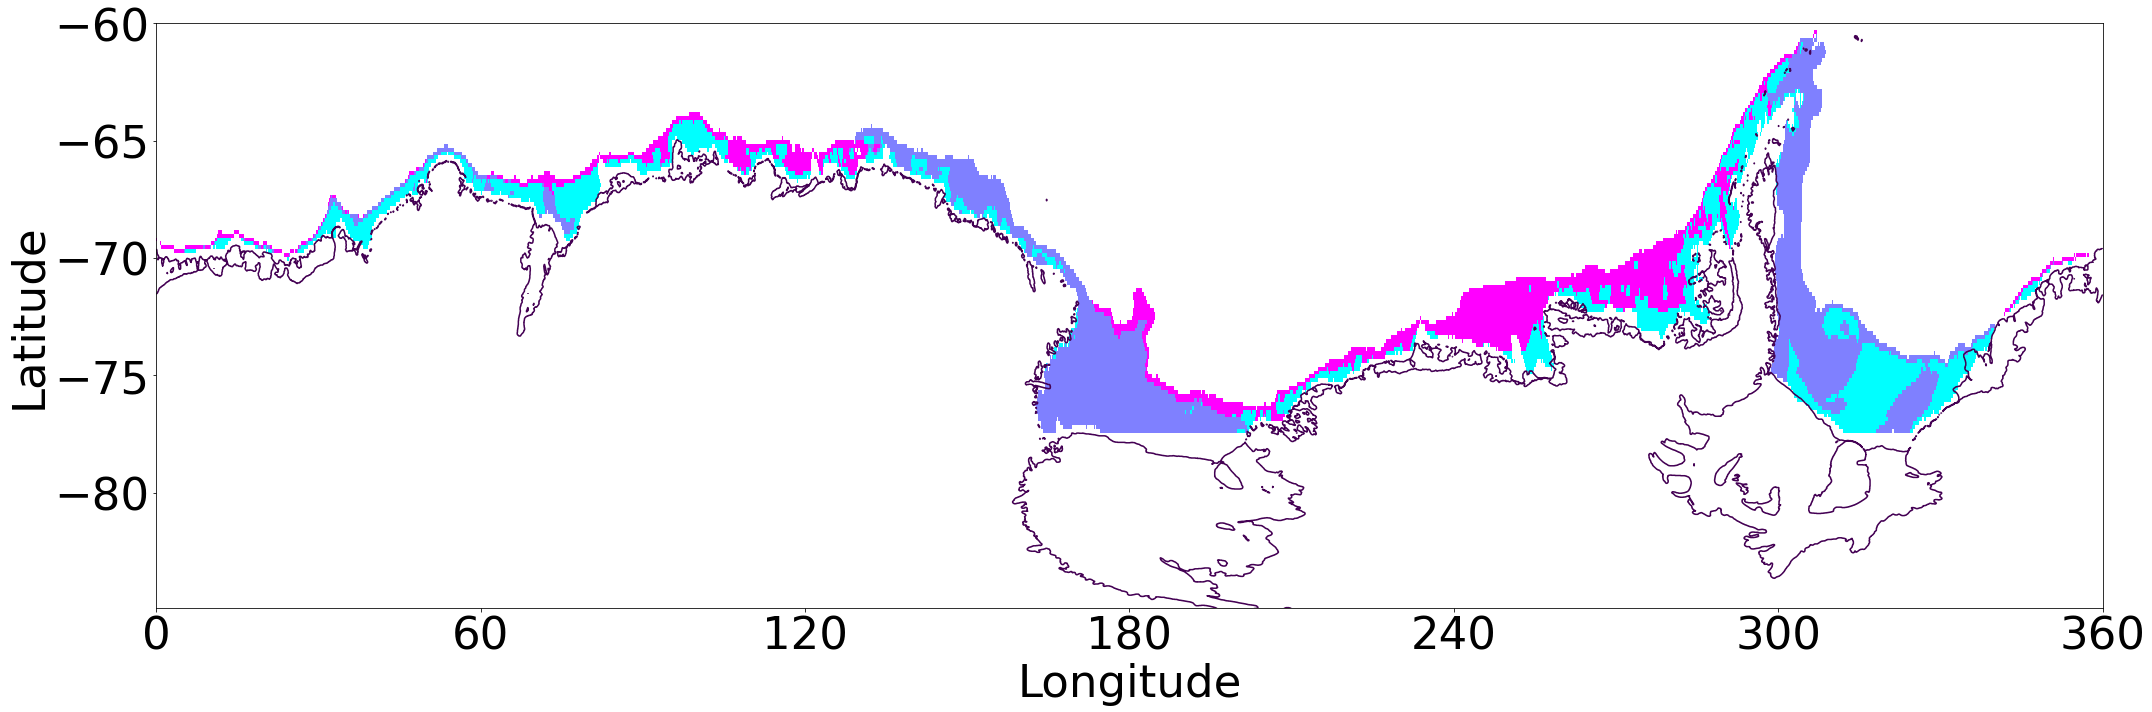

In [152]:
fig, ax = plt.subplots(figsize=(30,10))
#im = ax.pcolormesh(XC%360, YC, res)

cmap = plt.cm.get_cmap('cool')
# cmap.set_under('w')
# # cmap.set_over()  # do something here?
levels = np.asarray([0.5, 1.5, 2.5, 3.5])
im = ax.pcolormesh(XC%360, YC, res,
    cmap=cmap,
#     vmin=levels[0],
    # vmax=levels[-1],
    norm = mpl.colors.BoundaryNorm(levels, ncolors=cmap.N, clip=False)
)

ax.contour(ISX%360,ISY, IS, levels=[0,1])

# cbar_ax = fig.add_axes([0.1, 0.4, 0.35, 0.05])
# cbar = fig.colorbar(im, cax=cbar_ax,orientation='horizontal')
# cbar.ax.set_xlabel(f'', size=20)
# cbar.ax.set_xticks([1, 2, 3])
# cbar.ax.set_xticklabels(['Warm', 'Fresh', 'Dense'])
# cbar.ax.tick_params(labelsize=40)

ax.set_xlim(0,360)
ax.set_ylim(-84.9, -60)
ax.set_xticks(np.arange(0, 361, 60))

ax.set_xlabel('Longitude', fontsize=45)
ax.set_ylabel('Latitude', fontsize=45)
ax.tick_params(axis='both', labelsize=45)

# ax.grid()
plt.tight_layout()

plt.savefig('img/SOSE_ISclassify.jpg', dpi=300)

## Percent Warm

In [15]:
SOHI = np.load('data2/SOhi.npy')
LLC = np.load('data2/LLC.npy')
SOSE = np.load('data2/SOSE.npy')

In [ ]:
### 1 = Fresh, 2 = Dense, 3=Warm

In [16]:
total = np.count_nonzero(~np.isnan(SOHI))
warm = np.count_nonzero(SOHI == 3)
dense = np.count_nonzero(SOHI == 2)
fresh = np.count_nonzero(SOHI == 1)

print(total, warm, dense, fresh)
print(warm/total*100)
print(dense/total*100)
print(fresh/total*100)

87992 14319 54112 19561
16.273070279116283
61.49649968178925
22.23043003909446


In [17]:
total = np.count_nonzero(~np.isnan(LLC))
warm = np.count_nonzero(LLC == 3)
dense = np.count_nonzero(LLC == 2)
fresh = np.count_nonzero(LLC == 1)

print(total, warm, dense, fresh)
print(warm/total*100)
print(dense/total*100)
print(fresh/total*100)

73677 9225 38999 25453
12.520868113522537
52.93239409856536
34.5467377879121


In [18]:
total = np.count_nonzero(~np.isnan(SOSE))
warm = np.count_nonzero(SOSE == 3)
dense = np.count_nonzero(SOSE == 2)
fresh = np.count_nonzero(SOSE == 1)

print(total, warm, dense, fresh)
print(warm/total*100)
print(dense/total*100)
print(fresh/total*100)

24128 6121 10210 7797
25.36886604774536
42.31598143236074
32.3151525198939
